[View in Colaboratory](https://colab.research.google.com/github/mathcass/eigenlayout/blob/colab/Analysis.ipynb)

# Eigenlayouts

[![Edit in Collaboratory](https://cdn-images-1.medium.com/max/800/1*ZpNn76K98snC9vDiIJ6Ldw.jpeg)](https://colab.research.google.com/github/mathcass/eigenlayout/blob/master/Analysis.ipynb)

I originally started this project in mid-2016 after being inspired by a similar application in facial recognition. In facial recognition, applying PCA to a group of images gives you "eigenfaces" so I reasons, "Could we see something similar in websites and could it give insight into common patterns for building products online?" 

As mentioned, I wrote code to collect this data from the web using PhantomJS and GNU `make`. Here public links to the collected datasets:

* [Full top 10,000 Alexa dataset of images](https://storage.googleapis.com/mathcass-data/eigenlayout/images-100.tar.gz)
* [Random sample of images](https://storage.googleapis.com/mathcass-data/eigenlayout/images-sample.tar.gz)
* [Small sample of "interesting" websites](https://storage.googleapis.com/mathcass-data/eigenlayout/images.tar.gz)

Here's an [archive](https://storage.googleapis.com/mathcass-data/eigenlayout/top-1m.csv) of the top 1 million sites from Alexa as of April 2016. 

## Inspired reading

* [Sanger's Rule](https://www.carl-olsson.com/sangers-rule-bcm/)
* [Emergence of simple-cell receptive field properties by learning a sparse code for natural images](https://courses.cs.washington.edu/courses/cse528/11sp/Olshausen-nature-paper.pdf)
* [Faces dataset decompositions](http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html)
* [Implementation of Generalized Hebbian Algorithm](https://github.com/matwey/python-gha)

In [1]:
!pip freeze

absl-py==0.2.2
altair==2.0.1
astor==0.6.2
beautifulsoup4==4.6.0
bleach==1.5.0
cachetools==2.1.0
certifi==2018.4.16
chardet==3.0.4
crcmod==1.7
cycler==0.10.0
decorator==4.3.0
entrypoints==0.2.3
future==0.16.0
gast==0.2.0
google-api-core==1.1.2
google-api-python-client==1.6.7
google-auth==1.4.1
google-auth-httplib2==0.0.3
google-auth-oauthlib==0.2.0
google-cloud-bigquery==1.1.0
google-cloud-core==0.28.1
google-cloud-language==1.0.2
google-cloud-storage==1.8.0
google-cloud-translate==1.3.1
google-colab==0.0.1a1
google-resumable-media==0.3.1
googleapis-common-protos==1.5.3
grpcio==1.12.0
h5py==2.7.1
html5lib==0.9999999
httplib2==0.11.3
idna==2.6
ipykernel==4.6.1
ipython==5.5.0
ipython-genutils==0.2.0
Jinja2==2.10
jsonschema==2.6.0
jupyter-client==5.2.3
jupyter-core==4.4.0
Keras==2.1.6
Markdown==2.6.11
MarkupSafe==1.0
matplotlib==2.1.2
mistune==0.8.3
mpmath==1.0.0
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
nltk==3.2.5
notebook==5.2.2
numpy==1.14.3
oauth2client==4.1.2
oauthlib==2.0.7
ole

In [2]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['axes.grid'] = False

%matplotlib inline

## Amazons

We can already see how neat this data is when we look at the different variants of the website Amazon.com. Each one is slightly different based on regional interests as well as language.

In [3]:
!if [ ! -d images-sample ]; then wget "https://storage.googleapis.com/mathcass-data/eigenlayout/images-sample.tar.gz" && tar zxvf images-sample.tar.gz; fi

In [0]:
amazons = !ls images-sample/amazon*
amazon_images = np.array([io.imread(f) for f in amazons])
amazon_mean = amazon_images.mean(axis=0)

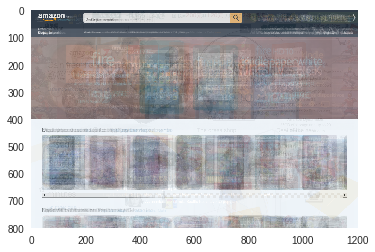

In [5]:
plt.imshow(amazon_mean.astype('uint8'))

# Image Components

We'd like to show that you can decompose the website images into components using techniques like PCA. Then, you can inspect and interpret the components in a way to make a decision about the website, like type, etc. 

In [6]:
!if [ ! -d images-random ]; then wget "https://storage.googleapis.com/mathcass-data/eigenlayout/images-random.tar.gz" && tar zxvf images-random.tar.gz; fi

image_files = !ls images-random/*.png

In [7]:
len(image_files)

1000

In [8]:
from skimage import transform

def resize_image(im):
    """Resizes image to 80px by 120px"""
    
    return transform.resize(im, (80, 120))

In [9]:
images = np.array([resize_image(io.imread(f)) for f in image_files])
images.shape

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1000, 80, 120, 4)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


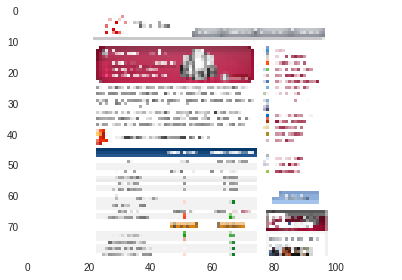

In [10]:
io.imshow(images[0])

In [11]:
from skimage import color

grey_images = np.array([color.rgb2grey(im) for im in images])

In [12]:
mean_image = grey_images.mean(axis=0)

In [13]:
show_grey = lambda im: io.imshow(im, cmap=plt.cm.gray)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


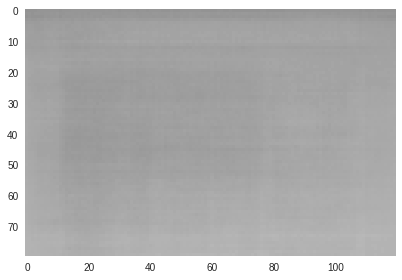

In [14]:
show_grey(mean_image)

In [15]:
centered_images = grey_images - mean_image

In [16]:
for i in range(centered_images.shape[0]):
    centered_images[i] -= centered_images[i].mean()

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


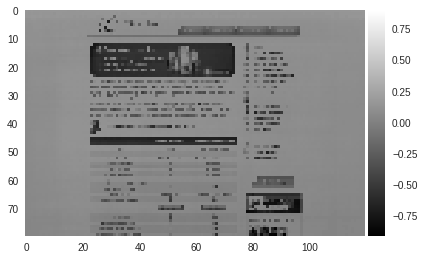

In [17]:
import matplotlib.pyplot as plt

show_grey(centered_images[0])

In [18]:
centered_images.shape

(1000, 80, 120)

In [19]:
centered_images.reshape(centered_images.shape[0], 80*120).shape

(1000, 9600)

In [20]:
reshaped_images = centered_images.reshape(centered_images.shape[0], 80*120)

In [21]:
%%time

from sklearn.decomposition import PCA

pca = PCA(n_components=centered_images.shape[0])
pca.fit(reshaped_images)

CPU times: user 12.6 s, sys: 1.94 s, total: 14.5 s
Wall time: 7.47 s


In [22]:
pca.components_.shape

(1000, 9600)

In [23]:
pca.transform(reshaped_images[0:1]).shape

(1, 1000)

We see how as we increase the number of components used to reconstruct an image, we recover more of the original image

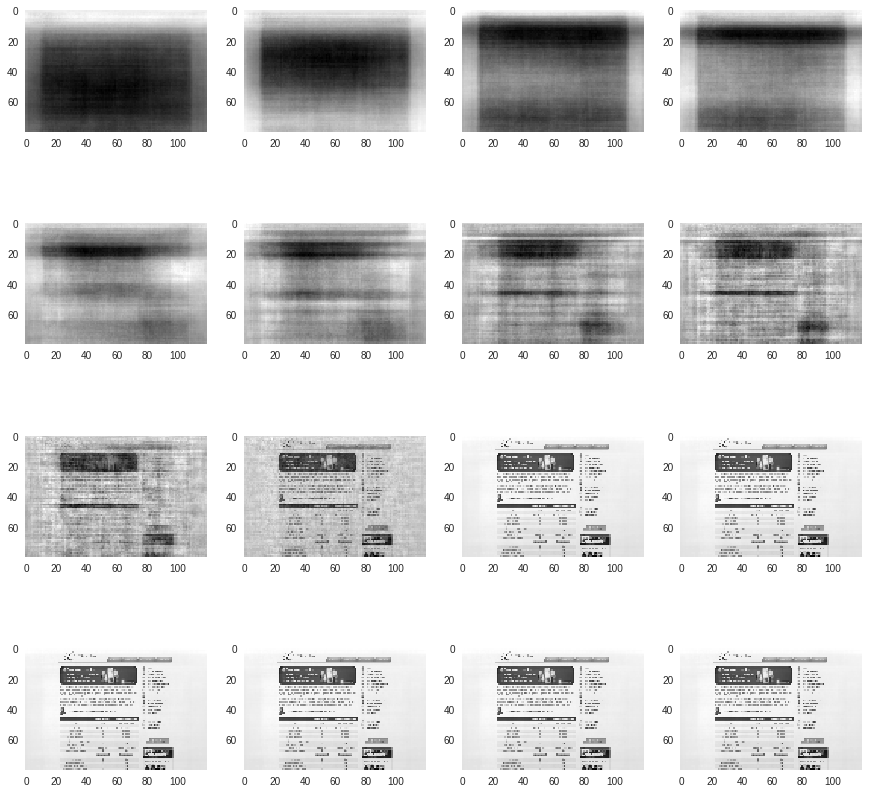

In [24]:
_, axes = plt.subplots(4, 4, figsize=(15, 15))

for i, ax in enumerate(axes.reshape(-1)): 
    _n = 2**i
    _im = np.dot(pca.transform(reshaped_images[0:1])[:, :_n], pca.components_[:_n])
    _im = _im.reshape((80, 120))
    ax.imshow(_im, cmap=plt.cm.gray)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


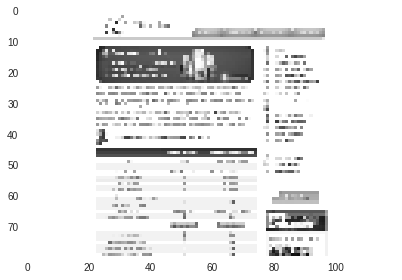

In [25]:
show_grey(grey_images[0])

In [26]:
component_images = pca.components_.reshape(*grey_images.shape)

In [27]:
component_images.shape

(1000, 80, 120)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


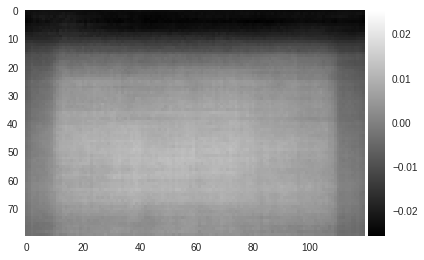

In [28]:
show_grey(component_images[0])

In [29]:
for i in range(10):
    n = 2**i
    print(f'Variance explained by {n} components: {np.sum(pca.explained_variance_ratio_[:n])}')

Variance explained by 1 components: 0.11221451243554748
Variance explained by 2 components: 0.20536535670176992
Variance explained by 4 components: 0.3178710727256196
Variance explained by 8 components: 0.4280627193821275
Variance explained by 16 components: 0.5300716570038295
Variance explained by 32 components: 0.6254731106636685
Variance explained by 64 components: 0.7163523195964473
Variance explained by 128 components: 0.8047307727534847
Variance explained by 256 components: 0.8887961203102475
Variance explained by 512 components: 0.9632301432013057


Below, we seem to have recovered some form of common website design. We see a top level nav portion, as well as a bottom nave. We see a possible nav line. We also see variations on either left or right 1/3 layout along with alternating content blocks.

The visual fields even seem to mimic the fields from [Olshausen and Field's paper](https://courses.cs.washington.edu/courses/cse528/11sp/Olshausen-nature-paper.pdf).

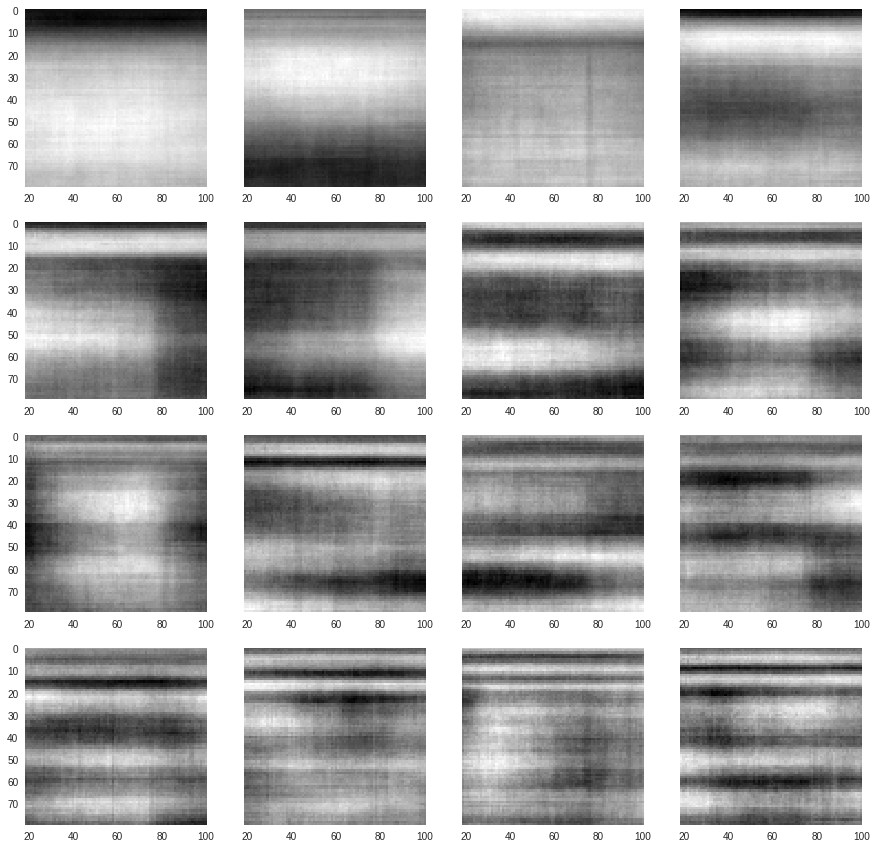

In [30]:
_, axes = plt.subplots(4, 4, sharey=True, figsize=(15, 15))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(component_images[i], cmap=plt.cm.gray)